In [17]:
library(coda)
library(rjags)

In [18]:
data <- read.csv("data/covid_dataset.csv")

In [19]:
model.loc <- ("model/multiv-ss_model.txt")

jagsscript <- cat("
model {  
   # process model priors
   u ~ dnorm(0, 0.01); # one u
   inv.q~dgamma(0.001,0.001);
   q <- 1/inv.q; # one q
   X0 ~ dnorm(Y1,0.001); # initial state
   # process model likelihood
   EX[1] <- X0 + u;
   X[1] ~ dnorm(EX[1], inv.q);
   for(t in 2:N) {
         EX[t] <- X[t-1] + u;
         X[t] ~ dnorm(EX[t], inv.q);
   }

   # observation model priors
   for(i in 1:n) { # r's differ by site
     inv.r[i]~dgamma(0.001,0.001);
     r[i] <- 1/inv.r[i];
   }
   a[1] <- 0; # first a is 0, rest estimated
   for(i in 2:n) {
     a[i]~dnorm(0,0.001);
   }   
   # observation model likelihood
   for(t in 1:N) {
     for(i in 1:n) {
       EY[i,t] <- X[t]+a[i]
       Y[i,t] ~ dnorm(EY[i,t], inv.r[i]);
     }
   }
}  

", 
    file = model.loc)

In [20]:
Y <- t(data[,c(2,4)])
Y

reported,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,8922.000000,1767.000000,1308.000000,9433.000000,4835.000000,7673.000000,4528.000000,7292.000000,1364.000000,1120.00000
mobility,3.654487,11.76576,-19.76016,-0.1938017,0.01421769,2.752245,0.802591,7.584535,12.76083,2.916388,⋯,-6.638448,-1.424815,-7.316044,-6.823921,-6.358453,-4.242926,-2.526319,-5.108635,-8.796637,-5.72277


In [21]:
X <- data$revised
length(X)
X[length(X)]<-NA

[1] 758

In [22]:
jags.data <- list(Y = Y, X = X,  n = nrow(Y), N = length(X), Y1 = 0)
jags.params <- c("q", "r", "u")
mod_ss <- jags.model(file = model.loc, data=jags.data)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1943
   Unobserved stochastic nodes: 337
   Total graph size: 4396

Initializing model



In [23]:
run_jag <- coda.samples(mod_ss, c("X[758]"), n.iter=100000)

In [24]:
summary(run_jag)


Iterations = 1:1e+05
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      1113.463        746.365          2.360          2.394 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
-344.7  611.5 1110.7 1615.9 2577.9 


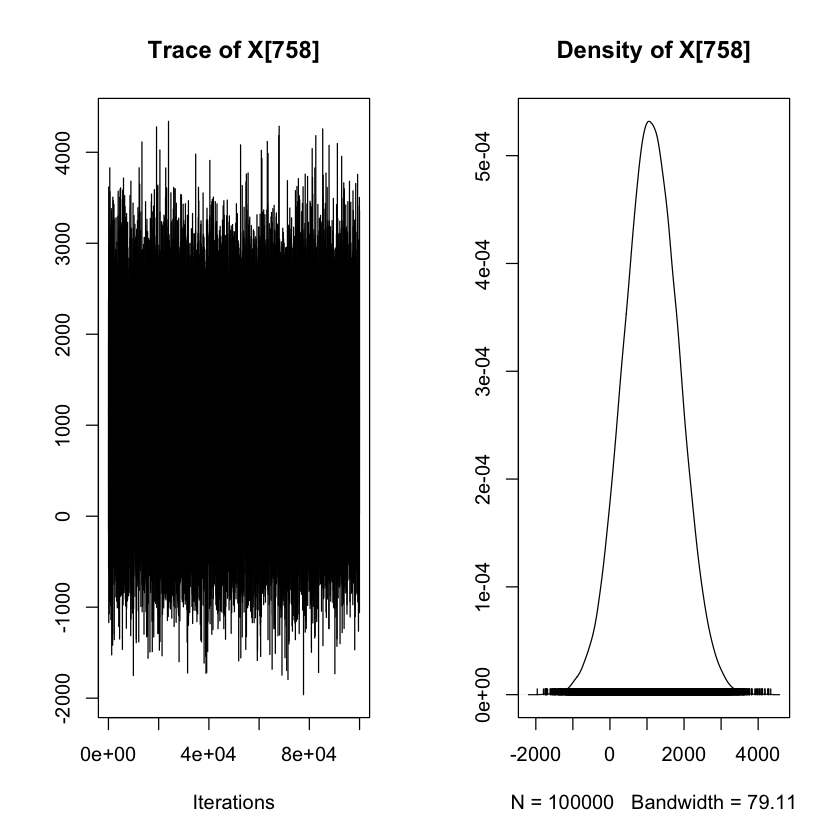

In [25]:
plot(run_jag)